Implementation of a GAN for CIFAR-10 dataset

In [13]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import os


In [14]:
print('==> Preparing data..')

#Just performing some transfomations on the image
transform_train = transforms.Compose([
        transforms.ToTensor()
])  

# So we need CIFAR-10 dataset , pytorch provides it!
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=2)

==> Preparing data..
Files already downloaded and verified


In [15]:
#Labels of Cifar-10 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#Hyper-Parameters--

#setting the learning rate
lr = 0.0002

#Number of samples to take a random distribution from
rand_num = 9

#Number of epochs
num_epochs = 200

#select min batch size
batch_size = 50

#Number of batches per Epoch
num_batches = len(trainloader)

# The Generator Network!

In [19]:
#Just a CNN with 4 convolution layers and 1 fully connected layers!
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 4*4*256),
            nn.LeakyReLU()
        )

        self.cnn = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=0, output_padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=0),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=2, output_padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.model(z)
        x = x.view(-1, 256, 4, 4)
        x = self.cnn(x)
        return x


# The Discriminator Network!

In [20]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(4*4*256, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(-1, 4*4*256)
        x = self.fc(x)
        return x

In [21]:
discriminator = Discriminator()
generator = Generator()

# The classification loss of Discriminator, binary classification, 1 -> real sample, 0 -> fake sample
criterion = nn.BCELoss()

# Define optimizers
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr)

# Draw 9 samples from the input distribution as a fixed test set
# Can follow how the generator output evolves
rand_z = Variable(torch.randn(rand_num, 100))

In [ ]:
gen_loss=[]
dis_loss=[]

for ep in range(num_epochs):
    for n, (images, _) in enumerate(trainloader):

        images = Variable(images)
        labels_real = Variable(torch.ones(batch_size))       # Labels for real images - all ones
        labels_fake = Variable(torch.zeros(batch_size))      # Labels for fake images - all ones

        # Train the discriminator, it tries to discriminate between real and fake (generated) samples
        discriminator.zero_grad()
        outputs = discriminator(images)
        loss_real = criterion(outputs, labels_real)

        z = Variable(torch.randn(batch_size, 100))
        images_fake = generator(z)
        outputs = discriminator(images_fake.detach())
        loss_fake = criterion(outputs, labels_fake)

        loss_d = loss_real + loss_fake              # Calculate the total loss
        loss_d.backward()                           # Backpropagation
        optimizer_d.step()                          # Update the weights

        # Train the generator, it tries to fool the discriminator
        # Draw samples from the input distribution and pass to generator
        z = Variable(torch.randn(batch_size, 100))
        images_fake = generator(z)

        # Pass the genrated images to discriminator
        outputs = discriminator(images_fake)

        generator.zero_grad()
        loss_g = criterion(outputs, labels_real)    # Calculate the loss
        loss_g.backward()                           # Backpropagation
        optimizer_g.step()                          # Update the weights

        if not n%10:
            print('epoch: {} - loss_d: {} - loss_g: {}'.format(ep, loss_d.data[0], loss_g.data[0]))

    # Save the test results after each Epoch
    print('Iter-{}; D_loss: {}; G_loss: {}'.format(ep, loss_d.data.cpu().numpy(), loss_g.data.numpy()))
    dis_loss.append(loss_d.data.numpy())
    gen_loss.append(loss_g.data.numpy())

/usr/local/lib/python2.7/dist-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch: 0 - loss_d: 1.38936007023 - loss_g: 0.674995243549
epoch: 0 - loss_d: 0.721411108971 - loss_g: 0.84409737587
epoch: 0 - loss_d: 0.125584468246 - loss_g: 2.55602574348
epoch: 0 - loss_d: 1.94820356369 - loss_g: 2.07185554504


In [11]:
import pickle
with open("./out-pytorch-gan/losses_pickles/genloss.pkl","wb") as f:
    pickle.dump(gen_loss,f)
    

In [12]:
with open("./out-pytorch-gan/losses_pickles/disloss.pkl","wb") as f:
    pickle.dump(dis_loss,f)

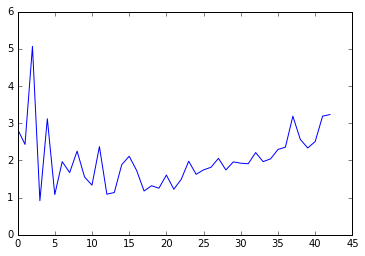

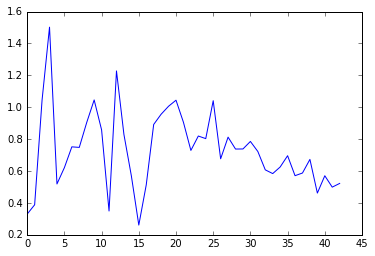

In [7]:
import matplotlib.pyplot as plt
plt.plot(g_loss)
plt.show()

plt.plot(d_loss)
plt.show()